<a href="https://colab.research.google.com/github/NerminWEST/Kaggle_Dataset_Fish_Model1.0/blob/main/MARINA_PLUS_Model_2_Router_Classifier_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("✓ Running on Google Colab")
else:
    print("✓ Running on Local Jupyter")

# %%
# Install required packages
!pip install torch torchvision torchaudio --quiet
!pip install ultralytics opencv-python-headless albumentations scikit-learn matplotlib seaborn pillow timm --quiet

# %%
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import cv2
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import time
from ultralytics import YOLO
import os

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Running on Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted!")

    # Paths
    YOLO_MODEL_PATH = '/content/drive/MyDrive/marina_plus_models/yolov8n_tuna_best.pt'
    TUNA_DATASET_PATH = '/content/drive/MyDrive/TunaDataset'
    ROUTER_SAVE_PATH = '/content/drive/MyDrive/marina_plus_models'

    # Copy to local for faster access
    LOCAL_YOLO_PATH = '/content/yolov8n_tuna_best.pt'
    LOCAL_DATASET_PATH = '/content/TunaDataset'

    if Path(YOLO_MODEL_PATH).exists():
        import shutil
        shutil.copy(YOLO_MODEL_PATH, LOCAL_YOLO_PATH)
        print(f"✓ YOLOv8 model copied to local storage")

    if Path(TUNA_DATASET_PATH).exists() and not Path(LOCAL_DATASET_PATH).exists():
        shutil.copytree(TUNA_DATASET_PATH, LOCAL_DATASET_PATH)
        print(f"✓ Dataset copied to local storage")
else:
    # Local Jupyter paths
    LOCAL_YOLO_PATH = './marina_plus/yolov8n_tuna/weights/best.pt'
    LOCAL_DATASET_PATH = './TunaDataset'
    ROUTER_SAVE_PATH = './marina_plus_models'

print(f"\n📁 Paths configured:")
print(f"  YOLOv8 Model: {LOCAL_YOLO_PATH}")
print(f"  Dataset: {LOCAL_DATASET_PATH}")
print(f"  Save path: {ROUTER_SAVE_PATH}")


Mounted at /content/drive
✓ Google Drive mounted!
✓ YOLOv8 model copied to local storage
✓ Dataset copied to local storage

📁 Paths configured:
  YOLOv8 Model: /content/yolov8n_tuna_best.pt
  Dataset: /content/TunaDataset
  Save path: /content/drive/MyDrive/marina_plus_models


In [ ]:
def extract_fish_crops_with_quality_assessment(
    yolo_model_path,
    dataset_path,
    output_path='./router_dataset',
    max_images_per_split=None,
    crop_size=(224, 224)
):
    """
    Intelligently extract fish crops and auto-label them based on quality metrics

    Quality Assessment Criteria:
    - CLEAR_SIDE: High contrast, sharp edges, side view, good lighting
    - ANGLED: Partial occlusion, moderate quality, angled view
    - TURBID: Low contrast, blurry, poor visibility, turbidity
    """

    print("="*70)
    print("AUTO-GENERATING ROUTER TRAINING DATA")
    print("="*70)

    # Load YOLOv8 model
    yolo = YOLO(yolo_model_path)
    print(f"✓ Loaded YOLOv8 model from: {yolo_model_path}")

    # Create output directories
    output_path = Path(output_path)
    for split in ['train', 'valid', 'test']:
        for cls in ['CLEAR_SIDE', 'ANGLED', 'TURBID']:
            (output_path / split / cls).mkdir(parents=True, exist_ok=True)

    dataset_path = Path(dataset_path)

    # Statistics
    stats = {
        'CLEAR_SIDE': {'train': 0, 'valid': 0, 'test': 0},
        'ANGLED': {'train': 0, 'valid': 0, 'test': 0},
        'TURBID': {'train': 0, 'valid': 0, 'test': 0}
    }

    # Process each split
    for split in ['train', 'valid', 'test']:
        img_path = dataset_path / split / 'images'

        if not img_path.exists():
            print(f"\n⚠️  {split} folder not found, skipping...")
            continue

        images = list(img_path.glob('*.jpg')) + list(img_path.glob('*.png'))

        if max_images_per_split:
            images = images[:max_images_per_split]

        print(f"\n📸 Processing {split} set ({len(images)} images)...")

        for img_file in tqdm(images, desc=f"{split}"):
            # Read image
            img = cv2.imread(str(img_file))
            if img is None:
                continue

            # Run YOLOv8 detection
            results = yolo.predict(img, conf=0.3, verbose=False)

            if len(results[0].boxes) == 0:
                continue

            # Process each detected fish
            for idx, box in enumerate(results[0].boxes):
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())

                # Add padding
                pad = 10
                x1 = max(0, x1 - pad)
                y1 = max(0, y1 - pad)
                x2 = min(img.shape[1], x2 + pad)
                y2 = min(img.shape[0], y2 + pad)

                # Extract crop
                crop = img[y1:y2, x1:x2]

                if crop.size == 0 or crop.shape[0] < 30 or crop.shape[1] < 30:
                    continue

                # Smart quality assessment
                quality_class = assess_crop_quality(crop)

                # Resize crop
                crop_resized = cv2.resize(crop, crop_size)

                # Save crop
                crop_filename = f"{img_file.stem}_fish{idx}_{quality_class}.jpg"
                save_path = output_path / split / quality_class / crop_filename
                cv2.imwrite(str(save_path), crop_resized)

                stats[quality_class][split] += 1

    # Print statistics
    print("\n" + "="*70)
    print("DATA GENERATION COMPLETE")
    print("="*70)

    for cls in ['CLEAR_SIDE', 'ANGLED', 'TURBID']:
        total = sum(stats[cls].values())
        print(f"\n{cls}:")
        print(f"  Train: {stats[cls]['train']}")
        print(f"  Valid: {stats[cls]['valid']}")
        print(f"  Test: {stats[cls]['test']}")
        print(f"  Total: {total}")

    total_crops = sum(sum(stats[cls].values()) for cls in stats)
    print(f"\n📊 Total crops generated: {total_crops}")

    return output_path, stats


def assess_crop_quality(crop):
    """
    Intelligent quality assessment using computer vision metrics

    Metrics:
    - Contrast: Laplacian variance
    - Sharpness: Edge density
    - Brightness: Mean intensity
    - Turbidity: Color variance
    - Aspect ratio: Side view vs angled
    """

    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    h, w = crop.shape[:2]

    # 1. Sharpness (Laplacian variance) - higher = sharper
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    # 2. Contrast (standard deviation)
    contrast = gray.std()

    # 3. Brightness
    brightness = gray.mean()

    # 4. Edge density
    edges = cv2.Canny(gray, 50, 150)
    edge_density = edges.sum() / (h * w)

    # 5. Color variance (turbidity indicator)
    color_var = np.mean([crop[:,:,i].var() for i in range(3)])

    # 6. Aspect ratio (side view tends to be elongated)
    aspect_ratio = max(w, h) / min(w, h)

    # Scoring system
    quality_score = 0

    # Sharp and clear
    if laplacian_var > 100 and contrast > 40:
        quality_score += 3
    elif laplacian_var > 50 and contrast > 25:
        quality_score += 2
    else:
        quality_score += 0

    # Good lighting
    if 80 < brightness < 180:
        quality_score += 2
    elif 60 < brightness < 200:
        quality_score += 1

    # High edge density (clear features)
    if edge_density > 0.1:
        quality_score += 2
    elif edge_density > 0.05:
        quality_score += 1

    # Side view (elongated)
    if aspect_ratio > 1.5:
        quality_score += 1

    # Classification based on score
    if quality_score >= 6 and laplacian_var > 80:
        return 'CLEAR_SIDE'
    elif quality_score >= 3 or (laplacian_var > 30 and contrast > 20):
        return 'ANGLED'
    else:
        return 'TURBID'


# %%
# Generate router dataset
print("🎨 Generating router training data...")
print("This will extract fish crops and auto-classify them by quality")

ROUTER_DATASET_PATH = './router_dataset'

router_dataset_path, dataset_stats = extract_fish_crops_with_quality_assessment(
    yolo_model_path=LOCAL_YOLO_PATH,
    dataset_path=LOCAL_DATASET_PATH,
    output_path=ROUTER_DATASET_PATH,
    max_images_per_split=None,  # Process all images (set to 100 for quick testing)
    crop_size=(224, 224)
)

🎨 Generating router training data...
This will extract fish crops and auto-classify them by quality
AUTO-GENERATING ROUTER TRAINING DATA
✓ Loaded YOLOv8 model from: /content/yolov8n_tuna_best.pt

📸 Processing train set (1313 images)...


train:   0%|          | 0/1313 [00:00<?, ?it/s]


📸 Processing valid set (79 images)...


valid:   0%|          | 0/79 [00:00<?, ?it/s]


📸 Processing test set (78 images)...


test:   0%|          | 0/78 [00:00<?, ?it/s]


DATA GENERATION COMPLETE

CLEAR_SIDE:
  Train: 704
  Valid: 70
  Test: 60
  Total: 834

ANGLED:
  Train: 3524
  Valid: 326
  Test: 266
  Total: 4116

TURBID:
  Train: 302
  Valid: 11
  Test: 20
  Total: 333

📊 Total crops generated: 5283


📸 Sample crops from each class:


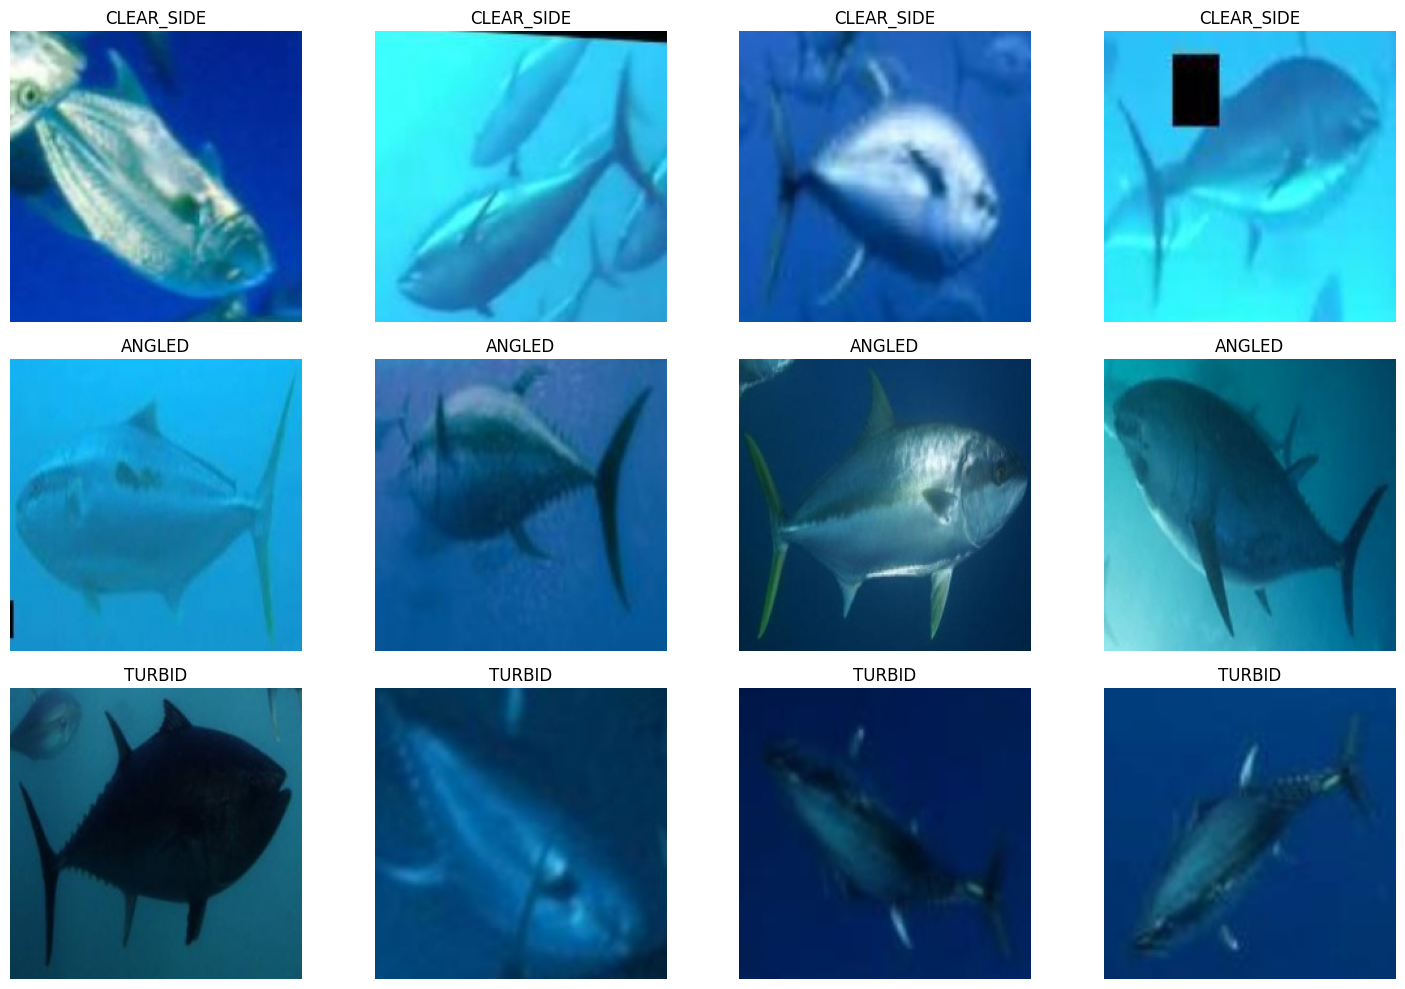

In [ ]:
def visualize_router_samples(dataset_path, samples_per_class=3):
    """
    Display sample crops from each quality class
    """

    dataset_path = Path(dataset_path)
    classes = ['CLEAR_SIDE', 'ANGLED', 'TURBID']

    fig, axes = plt.subplots(3, samples_per_class, figsize=(15, 10))

    for i, cls in enumerate(classes):
        cls_path = dataset_path / 'train' / cls
        images = list(cls_path.glob('*.jpg'))[:samples_per_class]

        for j, img_path in enumerate(images):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{cls}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig('router_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
print("📸 Sample crops from each class:")
visualize_router_samples(ROUTER_DATASET_PATH, samples_per_class=4)


In [ ]:
class RouterClassifier(nn.Module):
    """
    Lightweight Router Classifier for Raspberry Pi deployment

    Architecture:
    - MobileNetV3-Small backbone (pretrained)
    - Custom classification head
    - Optimized for edge inference
    """

    def __init__(self, num_classes=3, pretrained=True):
        super(RouterClassifier, self).__init__()

        # Use MobileNetV3-Small (efficient for edge devices)
        from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

        if pretrained:
            weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
            self.backbone = mobilenet_v3_small(weights=weights)
        else:
            self.backbone = mobilenet_v3_small(weights=None)

        # Replace classifier
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Hardswish(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)


class RouterClassifierWithFeatures(nn.Module):
    """
    Enhanced router with handcrafted features + CNN
    Combines deep learning with traditional CV metrics
    """

    def __init__(self, num_classes=3, pretrained=True):
        super(RouterClassifierWithFeatures, self).__init__()

        # CNN branch
        from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

        if pretrained:
            weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
            self.backbone = mobilenet_v3_small(weights=weights)
        else:
            self.backbone = mobilenet_v3_small(weights=None)

        # Remove final classifier
        self.backbone.classifier = nn.Identity()

        # Feature extraction head (will be populated during forward)
        # 6 handcrafted features: sharpness, contrast, brightness, edge_density, color_var, aspect_ratio
        self.feature_head = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        # Combined classifier
        cnn_features = 576  # MobileNetV3-Small output
        combined_features = cnn_features + 64

        self.classifier = nn.Sequential(
            nn.Linear(combined_features, 256),
            nn.Hardswish(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def extract_handcrafted_features(self, images_np):
        """
        Extract handcrafted features from batch of images
        images_np: numpy array (B, H, W, 3)
        """
        batch_size = images_np.shape[0]
        features = []

        for i in range(batch_size):
            img = images_np[i]
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            h, w = img.shape[:2]

            # 1. Sharpness
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

            # 2. Contrast
            contrast = gray.std()

            # 3. Brightness
            brightness = gray.mean()

            # 4. Edge density
            edges = cv2.Canny(gray, 50, 150)
            edge_density = edges.sum() / (h * w)

            # 5. Color variance
            color_var = np.mean([img[:,:,i].var() for i in range(3)])

            # 6. Aspect ratio
            aspect_ratio = max(w, h) / (min(w, h) + 1e-6)

            features.append([
                laplacian_var / 200.0,  # Normalize
                contrast / 100.0,
                brightness / 255.0,
                edge_density * 10.0,
                color_var / 10000.0,
                aspect_ratio / 3.0
            ])

        return torch.tensor(features, dtype=torch.float32)

    def forward(self, x, images_np=None):
        # CNN features
        cnn_features = self.backbone(x)

        # Handcrafted features (if provided)
        if images_np is not None:
            hand_features = self.extract_handcrafted_features(images_np).to(x.device)
            hand_features = self.feature_head(hand_features)

            # Concatenate features
            combined = torch.cat([cnn_features, hand_features], dim=1)
        else:
            # Use only CNN features with zero-padding
            zero_pad = torch.zeros(cnn_features.size(0), 64, device=x.device)
            combined = torch.cat([cnn_features, zero_pad], dim=1)

        # Classification
        output = self.classifier(combined)
        return output

In [ ]:
class RouterDataset(Dataset):
    """
    Dataset for router classifier training
    """

    def __init__(self, dataset_path, split='train', transform=None, return_numpy=False):
        self.dataset_path = Path(dataset_path) / split
        self.transform = transform
        self.return_numpy = return_numpy

        # Class mapping
        self.classes = ['CLEAR_SIDE', 'ANGLED', 'TURBID']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Collect all images
        self.samples = []
        for cls in self.classes:
            cls_path = self.dataset_path / cls
            if cls_path.exists():
                for img_path in cls_path.glob('*.jpg'):
                    self.samples.append((str(img_path), self.class_to_idx[cls]))

        print(f"{split} set: {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Store numpy version for handcrafted features
        image_np = image.copy() if self.return_numpy else None

        # Apply transforms
        if self.transform:
            image = self.transform(image=image)['image']

        if self.return_numpy:
            return image, torch.tensor(label, dtype=torch.long), image_np
        else:
            return image, torch.tensor(label, dtype=torch.long)


def get_transforms(augment=True):
    """
    Get transforms for training and validation
    """

    if augment:
        # Training transforms with augmentation
        transform = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.3),
            A.GaussNoise(p=0.2),
            A.HueSaturationValue(p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        # Validation/test transforms (no augmentation)
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    return transform


# %%
# Create datasets
USE_HANDCRAFTED_FEATURES = True  # Set to False for pure CNN approach

train_dataset = RouterDataset(
    ROUTER_DATASET_PATH,
    split='train',
    transform=get_transforms(augment=True),
    return_numpy=USE_HANDCRAFTED_FEATURES
)

valid_dataset = RouterDataset(
    ROUTER_DATASET_PATH,
    split='valid',
    transform=get_transforms(augment=False),
    return_numpy=USE_HANDCRAFTED_FEATURES
)

test_dataset = RouterDataset(
    ROUTER_DATASET_PATH,
    split='test',
    transform=get_transforms(augment=False),
    return_numpy=USE_HANDCRAFTED_FEATURES
)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✓ Dataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Valid batches: {len(valid_loader)}")
print(f"  Test batches: {len(test_loader)}")


train set: 4530 samples
valid set: 407 samples
test set: 346 samples

✓ Dataloaders created:
  Train batches: 142
  Valid batches: 13
  Test batches: 11


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model selection
if USE_HANDCRAFTED_FEATURES:
    model = RouterClassifierWithFeatures(num_classes=3, pretrained=True)
    print("✓ Using RouterClassifierWithFeatures (CNN + Handcrafted Features)")
else:
    model = RouterClassifier(num_classes=3, pretrained=True)
    print("✓ Using RouterClassifier (Pure CNN)")

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Training hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"\n📋 Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Scheduler: ReduceLROnPlateau")


Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 204MB/s]

✓ Using RouterClassifierWithFeatures (CNN + Handcrafted Features)
Total parameters: 1,126,723
Trainable parameters: 1,126,723

📋 Training Configuration:
  Epochs: 50
  Batch size: 32
  Learning rate: 0.001
  Weight decay: 0.0001
  Loss: CrossEntropyLoss
  Optimizer: Adam
  Scheduler: ReduceLROnPlateau


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, use_features=False):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')

    for batch in pbar:
        if use_features:
            images, labels, images_np = batch
            images_np = np.array(images_np)
        else:
            images, labels = batch
            images_np = None

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()

        if use_features:
            outputs = model(images, images_np)
        else:
            outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc


def validate_epoch(model, loader, criterion, device, use_features=False):
    """
    Validate for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')

        for batch in pbar:
            if use_features:
                images, labels, images_np = batch
                images_np = np.array(images_np)
            else:
                images, labels = batch
                images_np = None

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            if use_features:
                outputs = model(images, images_np)
            else:
                outputs = model(images)

            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{running_loss/len(pbar):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels


# %%
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_path = Path(ROUTER_SAVE_PATH) / 'router_classifier_best.pth'
best_model_path.parent.mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, USE_HANDCRAFTED_FEATURES
    )

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(
        model, valid_loader, criterion, device, USE_HANDCRAFTED_FEATURES
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time/60:.2f} minutes")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")



STARTING TRAINING

Epoch 1/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.5135 | Train Acc: 79.74%
  Val Loss: 0.6283 | Val Acc: 80.84%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 80.84%)

Epoch 2/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.4015 | Train Acc: 83.80%
  Val Loss: 0.6346 | Val Acc: 81.82%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 81.82%)

Epoch 3/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.3690 | Train Acc: 84.83%
  Val Loss: 0.3806 | Val Acc: 83.54%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 83.54%)

Epoch 4/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.3377 | Train Acc: 85.85%
  Val Loss: 0.3808 | Val Acc: 84.03%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 84.03%)

Epoch 5/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.3179 | Train Acc: 86.71%
  Val Loss: 0.4436 | Val Acc: 84.28%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 84.28%)

Epoch 6/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.2972 | Train Acc: 87.46%
  Val Loss: 0.4192 | Val Acc: 82.56%
  Learning Rate: 0.001000

Epoch 7/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 0.2667 | Train Acc: 88.90%
  Val Loss: 0.4371 | Val Acc: 78.13%
  Learning Rate: 0.001000

Epoch 8/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.2662 | Train Acc: 89.23%
  Val Loss: 0.3590 | Val Acc: 85.50%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 85.50%)

Epoch 9/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.2502 | Train Acc: 90.33%
  Val Loss: 0.3564 | Val Acc: 85.50%
  Learning Rate: 0.001000

Epoch 10/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.2406 | Train Acc: 89.71%
  Val Loss: 0.4116 | Val Acc: 85.01%
  Learning Rate: 0.001000

Epoch 11/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.2258 | Train Acc: 91.04%
  Val Loss: 0.3356 | Val Acc: 87.22%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 87.22%)

Epoch 12/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.2115 | Train Acc: 91.41%
  Val Loss: 0.3613 | Val Acc: 86.00%
  Learning Rate: 0.001000

Epoch 13/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>    
Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^

  File "/usr/lib/python

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.2082 | Train Acc: 92.05%
  Val Loss: 0.3253 | Val Acc: 88.45%
  Learning Rate: 0.001000
  ✓ Best model saved! (Val Acc: 88.45%)

Epoch 14/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.1897 | Train Acc: 92.74%
  Val Loss: 0.4719 | Val Acc: 83.54%
  Learning Rate: 0.001000

Epoch 15/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.1974 | Train Acc: 92.25%
  Val Loss: 0.3895 | Val Acc: 85.75%
  Learning Rate: 0.001000

Epoch 16/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 16 Summary:
  Train Loss: 0.1614 | Train Acc: 94.06%
  Val Loss: 0.5354 | Val Acc: 83.05%
  Learning Rate: 0.001000

Epoch 17/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 17 Summary:
  Train Loss: 0.1614 | Train Acc: 93.66%
  Val Loss: 0.4423 | Val Acc: 86.24%
  Learning Rate: 0.001000

Epoch 18/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 18 Summary:
  Train Loss: 0.1547 | Train Acc: 94.50%
  Val Loss: 0.4070 | Val Acc: 87.71%
  Learning Rate: 0.001000

Epoch 19/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 19 Summary:
  Train Loss: 0.1492 | Train Acc: 94.35%
  Val Loss: 0.6243 | Val Acc: 83.54%
  Learning Rate: 0.000500

Epoch 20/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 20 Summary:
  Train Loss: 0.1151 | Train Acc: 95.87%
  Val Loss: 0.5407 | Val Acc: 83.54%
  Learning Rate: 0.000500

Epoch 21/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 21 Summary:
  Train Loss: 0.0912 | Train Acc: 96.73%
  Val Loss: 0.4784 | Val Acc: 87.47%
  Learning Rate: 0.000500

Epoch 22/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 22 Summary:
  Train Loss: 0.1021 | Train Acc: 95.81%
  Val Loss: 0.4748 | Val Acc: 86.24%
  Learning Rate: 0.000500

Epoch 23/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^if w.is_alive():
^ ^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
   ^ ^ ^ ^   ^   ^^ ^^^^^^^^
^  File "


Epoch 23 Summary:
  Train Loss: 0.0898 | Train Acc: 96.47%
  Val Loss: 0.4787 | Val Acc: 86.98%
  Learning Rate: 0.000500

Epoch 24/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 24 Summary:
  Train Loss: 0.0902 | Train Acc: 96.64%
  Val Loss: 0.4820 | Val Acc: 88.45%
  Learning Rate: 0.000500

Epoch 25/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 25 Summary:
  Train Loss: 0.0763 | Train Acc: 97.40%
  Val Loss: 0.5695 | Val Acc: 86.49%
  Learning Rate: 0.000250

Epoch 26/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 26 Summary:
  Train Loss: 0.0663 | Train Acc: 97.11%
  Val Loss: 0.5672 | Val Acc: 87.22%
  Learning Rate: 0.000250

Epoch 27/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 27 Summary:
  Train Loss: 0.0543 | Train Acc: 97.95%
  Val Loss: 0.5561 | Val Acc: 86.98%
  Learning Rate: 0.000250

Epoch 28/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 28 Summary:
  Train Loss: 0.0534 | Train Acc: 98.01%
  Val Loss: 0.5803 | Val Acc: 86.49%
  Learning Rate: 0.000250

Epoch 29/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():
^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

 ^assert self._parent_pid == os.getpid(), 'can only test a child process'     ^    ^^ ^ ^^  ^^ ^ ^  ^
   File "/usr

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 29 Summary:
  Train Loss: 0.0535 | Train Acc: 97.90%
  Val Loss: 0.6525 | Val Acc: 84.52%
  Learning Rate: 0.000250

Epoch 30/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 30 Summary:
  Train Loss: 0.0461 | Train Acc: 98.37%
  Val Loss: 0.6877 | Val Acc: 86.49%
  Learning Rate: 0.000250

Epoch 31/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 31 Summary:
  Train Loss: 0.0536 | Train Acc: 98.23%
  Val Loss: 0.6492 | Val Acc: 85.50%
  Learning Rate: 0.000125

Epoch 32/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 32 Summary:
  Train Loss: 0.0486 | Train Acc: 98.08%
  Val Loss: 0.7368 | Val Acc: 85.26%
  Learning Rate: 0.000125

Epoch 33/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 33 Summary:
  Train Loss: 0.0417 | Train Acc: 98.39%
  Val Loss: 0.7442 | Val Acc: 87.22%
  Learning Rate: 0.000125

Epoch 34/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 34 Summary:
  Train Loss: 0.0381 | Train Acc: 98.52%
  Val Loss: 0.9082 | Val Acc: 86.00%
  Learning Rate: 0.000125

Epoch 35/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^ 
  File "/usr/lib/pyt

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 35 Summary:
  Train Loss: 0.0372 | Train Acc: 98.52%
  Val Loss: 0.8047 | Val Acc: 86.98%
  Learning Rate: 0.000125

Epoch 36/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 36 Summary:
  Train Loss: 0.0369 | Train Acc: 98.85%
  Val Loss: 0.9080 | Val Acc: 87.47%
  Learning Rate: 0.000125

Epoch 37/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 37 Summary:
  Train Loss: 0.0400 | Train Acc: 98.45%
  Val Loss: 0.8466 | Val Acc: 86.24%
  Learning Rate: 0.000063

Epoch 38/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 38 Summary:
  Train Loss: 0.0354 | Train Acc: 98.65%
  Val Loss: 0.8560 | Val Acc: 85.75%
  Learning Rate: 0.000063

Epoch 39/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 39 Summary:
  Train Loss: 0.0365 | Train Acc: 98.48%
  Val Loss: 0.8494 | Val Acc: 86.49%
  Learning Rate: 0.000063

Epoch 40/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 40 Summary:
  Train Loss: 0.0365 | Train Acc: 98.48%
  Val Loss: 0.8384 | Val Acc: 86.98%
  Learning Rate: 0.000063

Epoch 41/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:      <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^^  ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^
^  File "/

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 41 Summary:
  Train Loss: 0.0390 | Train Acc: 98.61%
  Val Loss: 0.7867 | Val Acc: 86.73%
  Learning Rate: 0.000063

Epoch 42/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 42 Summary:
  Train Loss: 0.0331 | Train Acc: 98.81%
  Val Loss: 0.8030 | Val Acc: 86.24%
  Learning Rate: 0.000063

Epoch 43/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 43 Summary:
  Train Loss: 0.0408 | Train Acc: 98.59%
  Val Loss: 0.8385 | Val Acc: 85.75%
  Learning Rate: 0.000031

Epoch 44/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 44 Summary:
  Train Loss: 0.0357 | Train Acc: 98.65%
  Val Loss: 0.8361 | Val Acc: 85.75%
  Learning Rate: 0.000031

Epoch 45/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 45 Summary:
  Train Loss: 0.0315 | Train Acc: 98.81%
  Val Loss: 0.8039 | Val Acc: 86.24%
  Learning Rate: 0.000031

Epoch 46/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 46 Summary:
  Train Loss: 0.0319 | Train Acc: 98.92%
  Val Loss: 0.8139 | Val Acc: 86.49%
  Learning Rate: 0.000031

Epoch 47/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70f44468e0>self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): 
    ^ ^  ^  ^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 47 Summary:
  Train Loss: 0.0338 | Train Acc: 98.85%
  Val Loss: 0.8212 | Val Acc: 86.49%
  Learning Rate: 0.000031

Epoch 48/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 48 Summary:
  Train Loss: 0.0323 | Train Acc: 98.83%
  Val Loss: 0.8376 | Val Acc: 86.00%
  Learning Rate: 0.000031

Epoch 49/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 49 Summary:
  Train Loss: 0.0343 | Train Acc: 98.83%
  Val Loss: 0.8210 | Val Acc: 86.98%
  Learning Rate: 0.000016

Epoch 50/50
----------------------------------------------------------------------


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 50 Summary:
  Train Loss: 0.0334 | Train Acc: 98.79%
  Val Loss: 0.8519 | Val Acc: 86.73%
  Learning Rate: 0.000016

✓ Training completed in 26.39 minutes
  Best validation accuracy: 88.45%


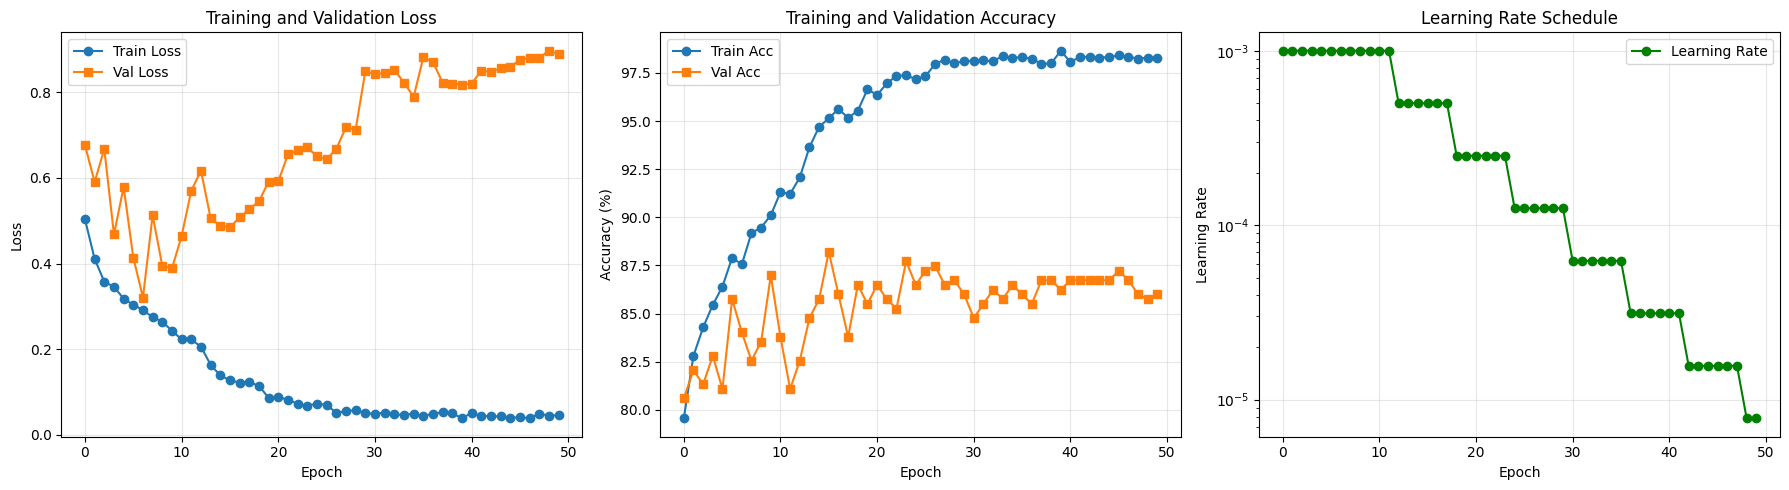

In [ ]:
# ##  Step 9: Visualize Training History

# %%
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate plot
axes[2].plot(history['lr'], label='Learning Rate', marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('router_training_history.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
# ## 🧪 Step 10: Evaluate on Test Set

# %%
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model (Val Acc: {checkpoint['val_acc']:.2f}%)")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate_epoch(
    model, test_loader, criterion, device, USE_HANDCRAFTED_FEATURES
)

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification report
class_names = ['CLEAR_SIDE', 'ANGLED', 'TURBID']
print("\n📊 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# Calculate per-class F1 scores
f1_scores = f1_score(test_labels, test_preds, average=None)
print("\n🎯 Per-Class F1 Scores:")
for i, cls in enumerate(class_names):
    print(f"  {cls}: {f1_scores[i]:.4f}")



NameError: name 'torch' is not defined

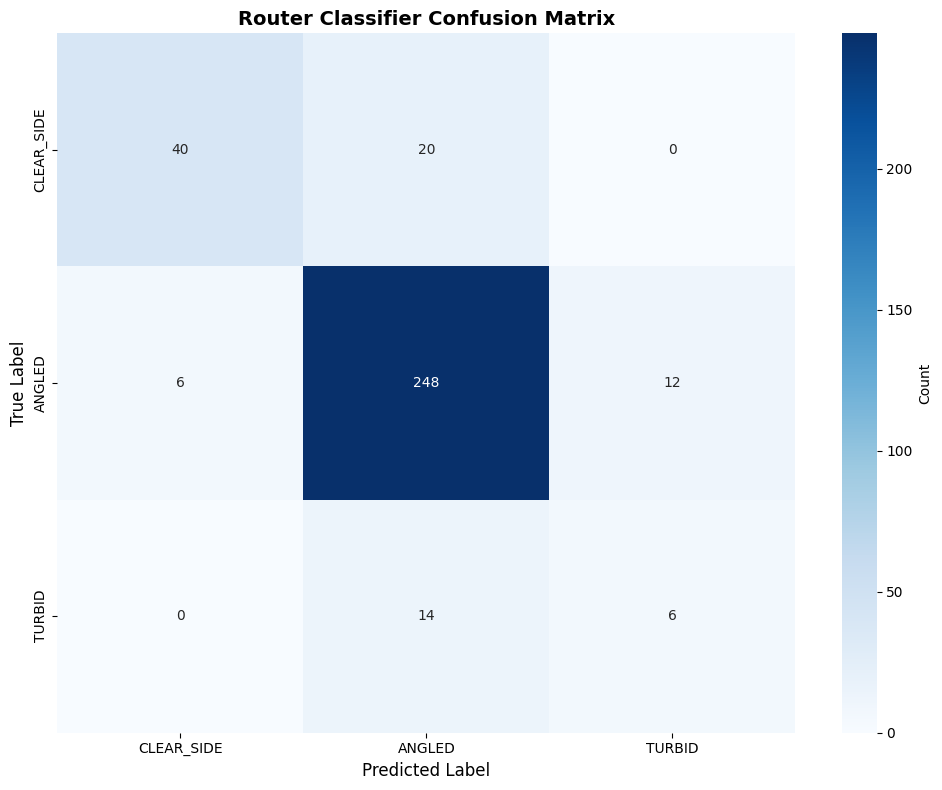

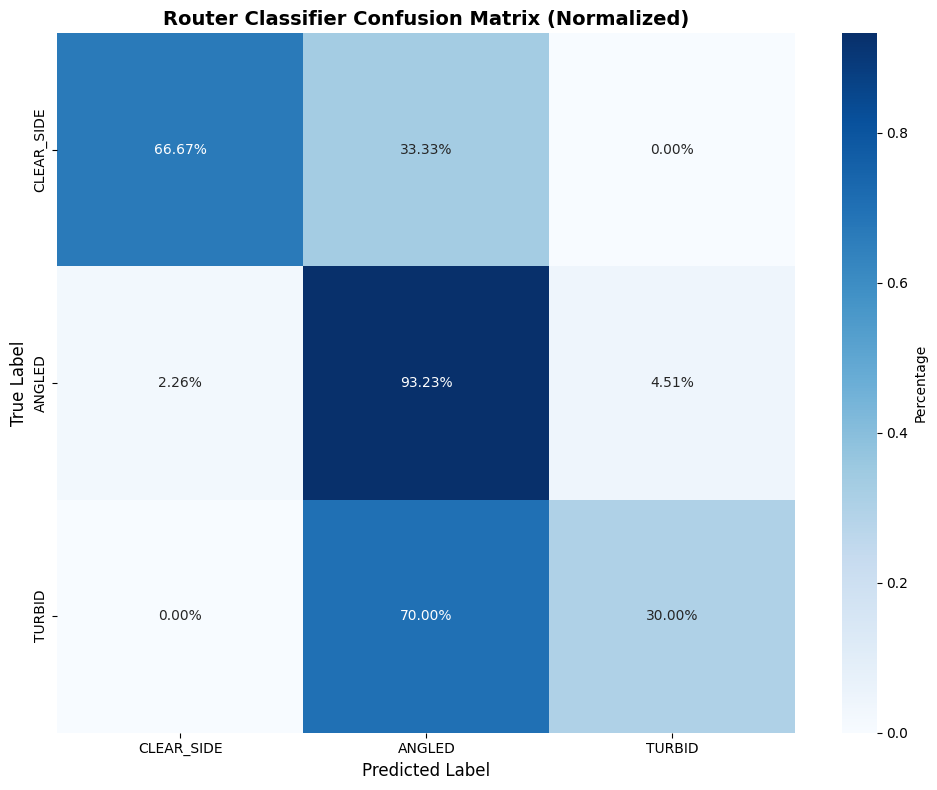

In [ ]:
# ## 📈 Step 11: Confusion Matrix

# %%
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Router Classifier Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('router_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Router Classifier Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('router_confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

🎨 Visualizing predictions on test set:


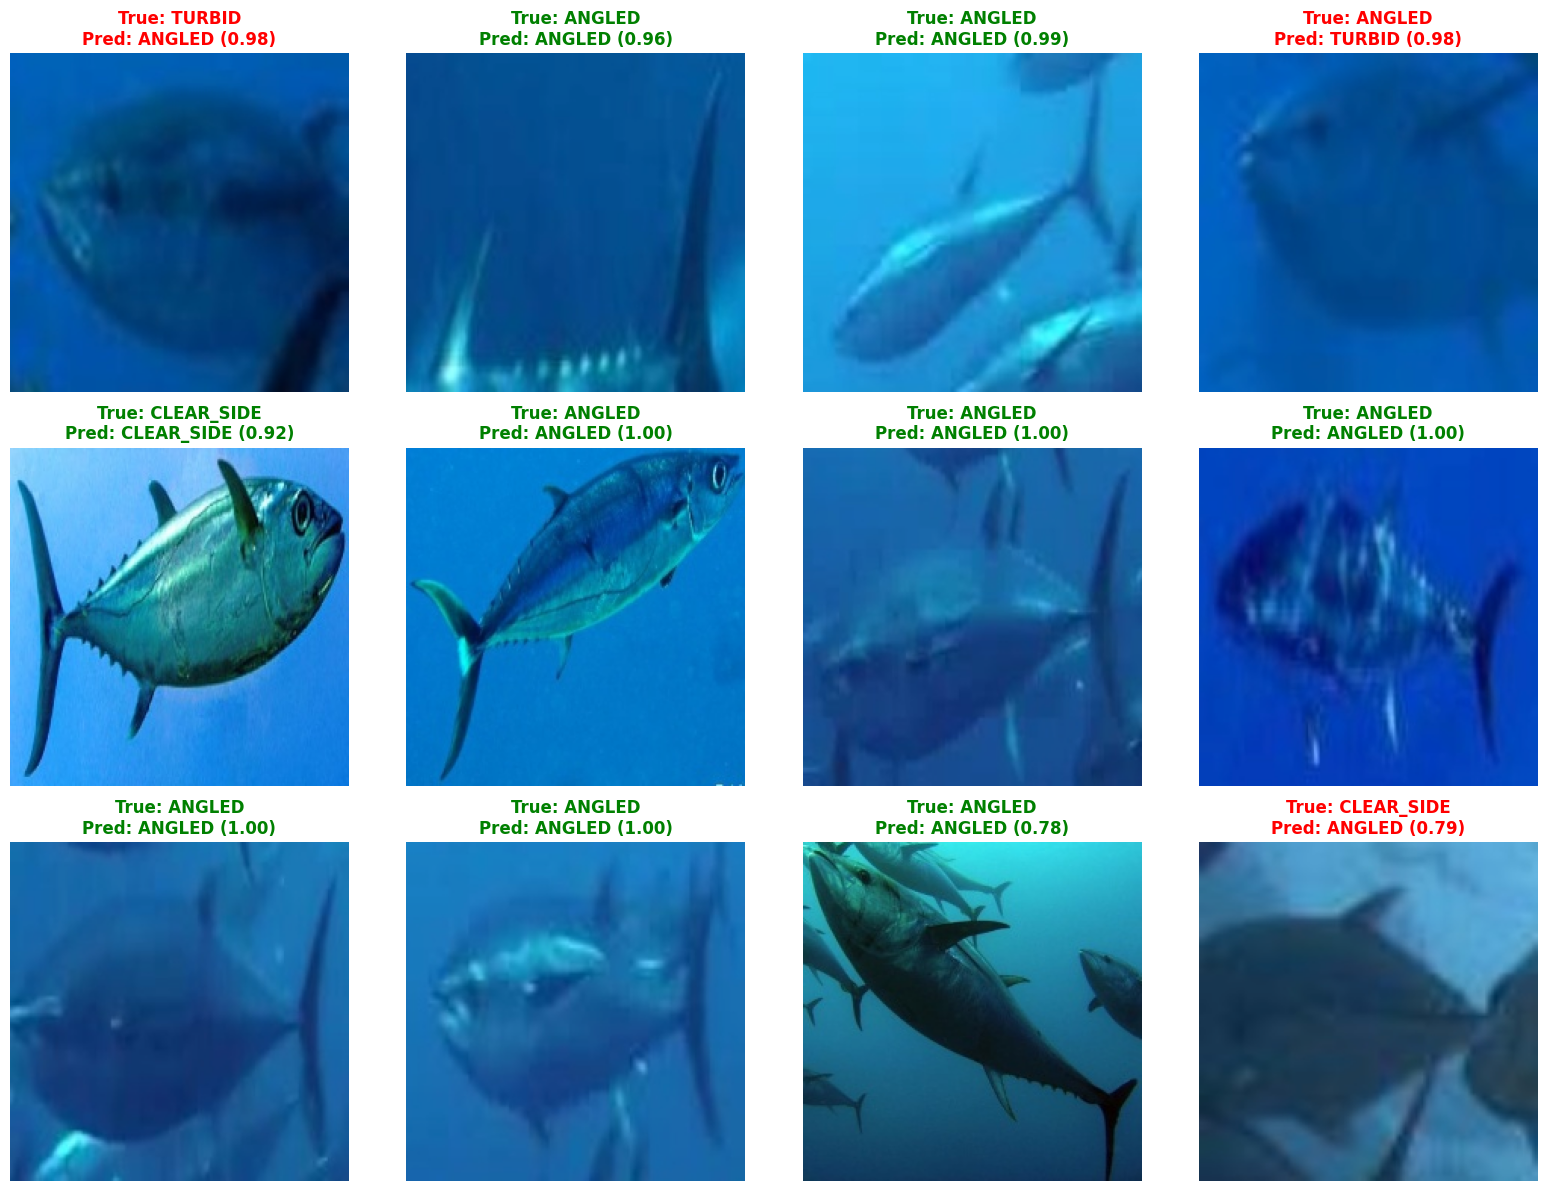

In [ ]:
# ## 🎨 Step 12: Visualize Predictions

# %%
def visualize_predictions(model, dataset, device, num_samples=12, use_features=False):
    """
    Visualize model predictions on random samples
    """
    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    class_names = ['CLEAR_SIDE', 'ANGLED', 'TURBID']

    with torch.no_grad():
        for idx, ax in zip(indices, axes):
            if use_features:
                image, label, image_np = dataset[idx]
                image_np = np.array([image_np])
            else:
                image, label = dataset[idx]
                image_np = None

            # Denormalize for display
            img_display = image.permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)

            # Predict
            image_batch = image.unsqueeze(0).to(device)
            if use_features:
                output = model(image_batch, image_np)
            else:
                output = model(image_batch)

            pred = output.argmax(1).item()
            confidence = F.softmax(output, dim=1)[0, pred].item()

            # Plot
            ax.imshow(img_display)
            true_label = class_names[label]
            pred_label = class_names[pred]
            color = 'green' if pred == label else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})',
                        color=color, fontweight='bold')
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('router_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
print("🎨 Visualizing predictions on test set:")
visualize_predictions(model, test_dataset, device, num_samples=12, use_features=USE_HANDCRAFTED_FEATURES)


In [ ]:
# ## 💾 Step 13: Export Model for Deployment

# %%
# Export to TorchScript for deployment
model.eval()
example_input = torch.randn(1, 3, 224, 224).to(device)

if USE_HANDCRAFTED_FEATURES:
    print("⚠️  Note: Model uses handcrafted features - export for inference wrapper")
    # Save full model with feature extraction capability
    export_path = Path(ROUTER_SAVE_PATH) / 'router_classifier_full.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_class': 'RouterClassifierWithFeatures',
        'use_handcrafted_features': True,
        'test_acc': test_acc,
    }, export_path)
    print(f"✓ Full model saved: {export_path}")
else:
    # Export to TorchScript
    traced_model = torch.jit.trace(model, example_input)
    torchscript_path = Path(ROUTER_SAVE_PATH) / 'router_classifier.pt'
    traced_model.save(str(torchscript_path))
    print(f"✓ TorchScript model saved: {torchscript_path}")

# Export to ONNX
try:
    onnx_path = Path(ROUTER_SAVE_PATH) / 'router_classifier.onnx'
    torch.onnx.export(
        model,
        example_input,
        str(onnx_path),
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"✓ ONNX model saved: {onnx_path}")
except Exception as e:
    print(f"⚠️  ONNX export failed: {e}")

# Save training history
history_path = Path(ROUTER_SAVE_PATH) / 'router_training_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f"✓ Training history saved: {history_path}")


NameError: name 'model' is not defined

🧪 Testing inference function:
  Predicted: CLEAR_SIDE (confidence: 0.9930)


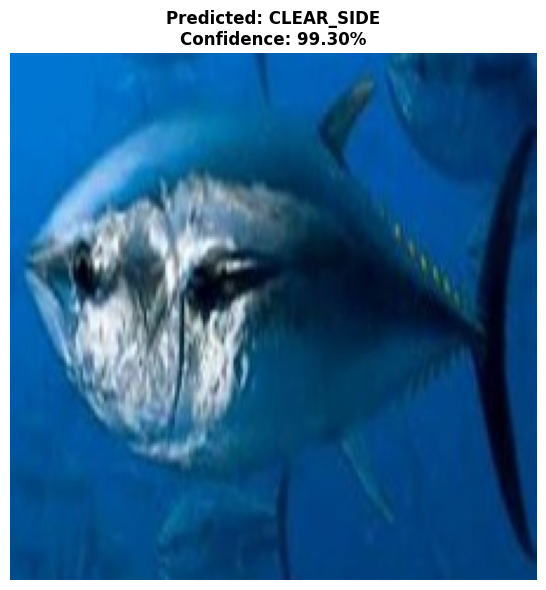

In [ ]:
# ## 🚀 Step 14: Inference Function

# %%
def infer_router_class(model, image, device, use_features=False, return_confidence=True):
    """
    Inference function for single image

    Args:
        model: Trained router classifier
        image: PIL Image or numpy array (H, W, 3)
        device: torch device
        use_features: Whether to use handcrafted features
        return_confidence: Return confidence score

    Returns:
        class_name: str ('CLEAR_SIDE', 'ANGLED', 'TURBID')
        confidence: float (if return_confidence=True)
    """
    model.eval()

    class_names = ['CLEAR_SIDE', 'ANGLED', 'TURBID']

    # Preprocess image
    if isinstance(image, np.ndarray):
        image_np = image.copy()
    else:
        image_np = np.array(image)

    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image_tensor = transform(image=image_np)['image'].unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        if use_features:
            image_np_batch = np.array([image_np])
            output = model(image_tensor, image_np_batch)
        else:
            output = model(image_tensor)

        probabilities = F.softmax(output, dim=1)[0]
        pred_class = output.argmax(1).item()
        confidence = probabilities[pred_class].item()

    class_name = class_names[pred_class]

    if return_confidence:
        return class_name, confidence
    else:
        return class_name


# Test inference function
print("🧪 Testing inference function:")
test_image_path = list((Path(ROUTER_DATASET_PATH) / 'test' / 'CLEAR_SIDE').glob('*.jpg'))[0]
test_image = cv2.imread(str(test_image_path))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

predicted_class, confidence = infer_router_class(
    model, test_image, device, USE_HANDCRAFTED_FEATURES, return_confidence=True
)

print(f"  Predicted: {predicted_class} (confidence: {confidence:.4f})")

plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}", fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()
